# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingClassifier
from sklearn.utils import check_array
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.base import clone
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import warnings
import shutil
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    
    target = 'target'
    n_folds = 6
    seed = 892

# Loading and processing the datasets

In [3]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 
    'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 
    'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 
    'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 
    'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 
    'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 
    'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 
    'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

new_num_cols = [
    'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 
    'lesion_color_difference', 'border_complexity', 'color_uniformity', 
    'position_distance_3d', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio', 
    'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 
    'color_consistency', 'consistency_color', 'size_age_interaction', 
    'hue_color_std_interaction', 'lesion_severity_index', 'shape_complexity_index', 
    'color_contrast_index', 'log_lesion_area', 'normalized_lesion_size', 
    'mean_hue_difference', 'std_dev_contrast', 'color_shape_composite_index', 
    'lesion_orientation_3d', 'overall_color_difference', 'symmetry_perimeter_interaction', 
    'comprehensive_lesion_index', 'color_variance_ratio', 'border_color_interaction', 
    'border_color_interaction_2', 'size_color_contrast_ratio', 'age_normalized_nevi_confidence', 
    'age_normalized_nevi_confidence_2', 'color_asymmetry_index', 'volume_approximation_3d', 
    'color_range', 'shape_color_consistency', 'border_length_ratio', 
    'age_size_symmetry_index', 'index_age_size_symmetry'
]

cat_cols = [
    'sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 
    'tbp_lv_location_simple', 'attribution'
]

norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

In [4]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )
        .with_columns(
            lesion_size_ratio              = pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index             = pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast                   = (pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast             = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference        = (pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity              = pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity               = pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + 1e-5),
        )
        .with_columns(
            position_distance_3d           = (pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio        = pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio        = pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score        = pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site       = pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border    = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency              = pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color              = pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction           = pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction      = pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index          = (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index         = pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index           = pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area                = (pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size         = pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference            = (pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast               = ((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index    = (pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d          = pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference       = (pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction = pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index     = (pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio           = pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction       = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2     = pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio      = pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence = pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2 = (pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index          = pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d        = pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range                    = (pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency        = pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio            = pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index        = pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry        = pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + 1e-5)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index('isic_id')
    )

In [5]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def preprocess(df_train, df_test):
    global cat_cols
    
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols
    
    return df_train, df_test

In [6]:
train = read_data(CFG.train_path)
test = read_data(CFG.test_path)
train, test = preprocess(train, test)

In [7]:
X = train.drop(CFG.target, axis=1)[feature_cols]
y = train[CFG.target]

X_test = test[feature_cols]

groups = train['patient_id']

# Training base models

In [8]:
def p_roc_auc_score(y_true, y_pred):
    min_tpr = 0.80
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0*np.asarray(y_pred)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError('Expected min_tpr in range [0, 1), got: %r' % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, 'right')
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

In [9]:
class Trainer:
    def __init__(self, model, n_folds=CFG.n_folds):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        if isinstance(self.model, Pipeline):
            print(f'Training {self.model.steps[1][1].__class__.__name__}\n')
        else:
            print(f'Training {self.model.__class__.__name__}\n')

        scores = []
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))

        split = StratifiedGroupKFold(n_splits=self.n_folds, random_state=CFG.seed, shuffle=True).split(X, y, groups=groups)            
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)

            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs

            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds

            score = p_roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)

            del model
            gc.collect()

            print(f'--- Fold {fold_idx + 1} - pAUC: {score:.6f}')

        print(f'\n\n------ pAUC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        return oof_pred_probs, test_pred_probs, scores

In [10]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
lgbm_params = {
    'objective':        'binary',
    'verbosity':        -1,
    'n_iter':           200,
    'boosting_type':    'gbdt',
    'random_state':     CFG.seed,
    'lambda_l1':        0.08758718919397321, 
    'lambda_l2':        0.0039689175176025465, 
    'learning_rate':    0.03231007103195577, 
    'max_depth':        4, 
    'num_leaves':       103, 
    'colsample_bytree': 0.8329551585827726, 
    'colsample_bynode': 0.4025961355653304, 
    'bagging_fraction': 0.7738954452473223, 
    'bagging_freq':     4, 
    'min_data_in_leaf': 85, 
    'scale_pos_weight': 2.7984184778875543,
}

cb_params = {
    'loss_function':     'Logloss',
    'iterations':        200,
    'verbose':           False,
    'random_state':      CFG.seed,
    'max_depth':         7, 
    'learning_rate':     0.06936242010150652, 
    'scale_pos_weight':  2.6149345838209532, 
    'l2_leaf_reg':       6.216113851699493, 
    'subsample':         0.6249261779711819, 
    'min_data_in_leaf':  24,
    'cat_features':      cat_cols,
}

xgb_params = {
    'enable_categorical': True,
    'tree_method':        'hist',
    'random_state':       CFG.seed,
    'learning_rate':      0.08501257473292347, 
    'lambda':             8.879624125465703, 
    'alpha':              0.6779926606782505, 
    'max_depth':          6, 
    'subsample':          0.6012681388711075, 
    'colsample_bytree':   0.8437772277074493, 
    'colsample_bylevel':  0.5476090898823716, 
    'colsample_bynode':   0.9928601203635129, 
    'scale_pos_weight':   3.29440313334688,
}

In [11]:
paucs = {}

test_pred_probs = {}
oof_pred_probs = {}

In [12]:
lgbm_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', LGBMClassifier(**lgbm_params)),
])
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_test_pred_probs, lgbm_scores = lgbm_trainer.fit_predict(X, y, X_test)
oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
paucs['LightGBM'] = lgbm_scores

Training LGBMClassifier

--- Fold 1 - pAUC: 0.182931
--- Fold 2 - pAUC: 0.167739
--- Fold 3 - pAUC: 0.166918
--- Fold 4 - pAUC: 0.168298
--- Fold 5 - pAUC: 0.177184
--- Fold 6 - pAUC: 0.166954


------ pAUC: 0.171671 ± 0.006176


In [13]:
cb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', CatBoostClassifier(**cb_params)),
])
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_test_pred_probs, cb_scores = cb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['CatBoost'] = cb_oof_pred_probs
test_pred_probs['CatBoost'] = cb_test_pred_probs
paucs['CatBoost'] = cb_scores

Training CatBoostClassifier

--- Fold 1 - pAUC: 0.178451
--- Fold 2 - pAUC: 0.157620
--- Fold 3 - pAUC: 0.155305
--- Fold 4 - pAUC: 0.166511
--- Fold 5 - pAUC: 0.174913
--- Fold 6 - pAUC: 0.162113


------ pAUC: 0.165819 ± 0.008507


In [14]:
xgb_model = Pipeline([
    ('sampler', RandomUnderSampler(sampling_strategy=0.01, random_state=CFG.seed)),
    ('classifier', XGBClassifier(**xgb_params)),
])
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_test_pred_probs, xgb_scores = xgb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
paucs['XGBoost'] = xgb_scores

Training XGBClassifier

--- Fold 1 - pAUC: 0.181849
--- Fold 2 - pAUC: 0.166393
--- Fold 3 - pAUC: 0.154403
--- Fold 4 - pAUC: 0.168948
--- Fold 5 - pAUC: 0.175093
--- Fold 6 - pAUC: 0.167391


------ pAUC: 0.169013 ± 0.008413


# Training a stacking classifier using oof predictions

In [15]:
class PassThroughClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, idx_cols):
        self.idx_cols = idx_cols
        self.is_fitted_ = True

    def fit(self, X, y=None):
        return self

    def predict_proba(self, X):
        return check_array(X)[:, self.idx_cols]


X_oof_pred_probs = np.log(pd.DataFrame(np.hstack(list(oof_pred_probs.values()))) + 1e-7)
X_test_pred_probs = np.log(pd.DataFrame(np.hstack(list(test_pred_probs.values()))) + 1e-7)

estimators = [
    ('LightGBM', PassThroughClassifier(list(range(0, 2)))),
    ('CatBoost', PassThroughClassifier(list(range(2, 4)))),
    ('XGBoost',  PassThroughClassifier(list(range(4, 6)))),
]

stacking_model = StackingClassifier(estimators, cv='prefit', n_jobs=-1)
stacking_trainer = Trainer(stacking_model)
stacking_oof_pred_probs, stacking_oof_preds, stacking_scores = stacking_trainer.fit_predict(X_oof_pred_probs, y, X_test_pred_probs)
oof_pred_probs['Stacking'] = stacking_oof_pred_probs
test_pred_probs['Stacking'] = stacking_oof_preds
paucs['Stacking'] = stacking_scores

Training StackingClassifier

--- Fold 1 - pAUC: 0.182928
--- Fold 2 - pAUC: 0.165068
--- Fold 3 - pAUC: 0.159927
--- Fold 4 - pAUC: 0.170651
--- Fold 5 - pAUC: 0.177947
--- Fold 6 - pAUC: 0.167741


------ pAUC: 0.170710 ± 0.007731


# Visualizing the results

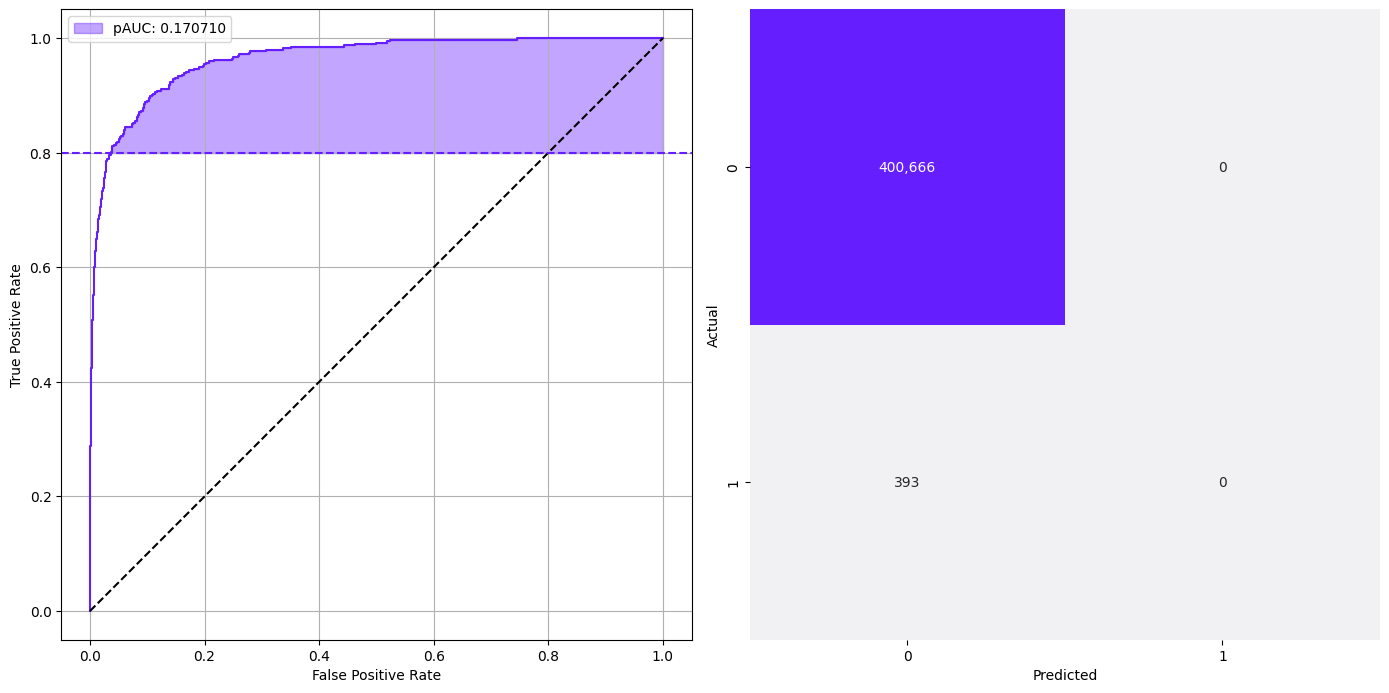

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, _ = roc_curve(y, oof_pred_probs['Stacking'][:, 1])
axes[0].plot(fpr, tpr, color='#651FFF')
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), color='#651FFF', alpha=0.4, label=f'pAUC: {np.mean(stacking_scores):.6f}')
axes[0].axhline(y=0.8, color='#651FFF', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

y_pred = oof_pred_probs['Stacking'].argmax(axis=1)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette('#651FFF', reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

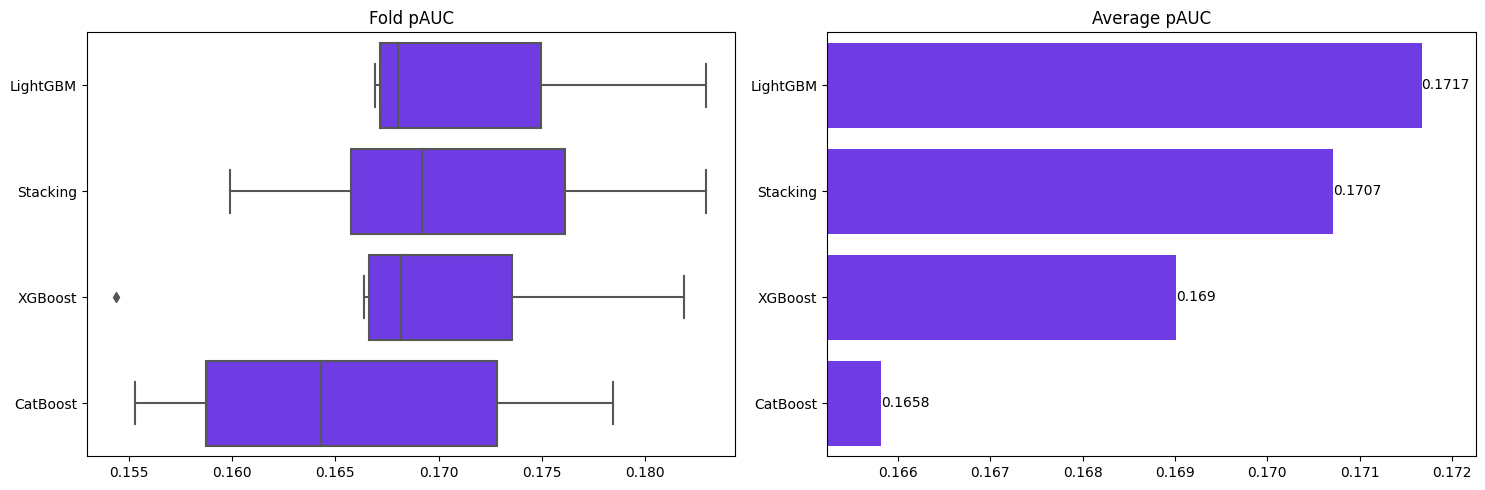

In [17]:
paucs = pd.DataFrame(paucs)
mean_paucs = paucs.mean().sort_values(ascending=False)
order = paucs.mean().sort_values(ascending=False).index.tolist()

min_pauc = mean_paucs.min()
max_pauc = mean_paucs.max()
padding = (max_pauc - min_pauc) * 0.1
lower_limit = min_pauc - padding
upper_limit = max_pauc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=paucs, order=order, ax=axs[0], orient='h', color='#651FFF')
axs[0].set_title('Fold pAUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_paucs.values, y=mean_paucs.index, ax=axs[1], color='#651FFF')
axs[1].set_title('Average pAUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_paucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

# Submission

In [18]:
sub = pd.read_csv('/kaggle/input/isic-2024-challenge/sample_submission.csv')
sub['isic_id'] = sub['isic_id']
sub[CFG.target] = test_pred_probs['Stacking'][:, 1]
sub.to_csv('submission.csv', index=False)
sub.head()

,isic_id,target
0,ISIC_0015657,0.085255
1,ISIC_0015729,0.056662
2,ISIC_0015740,0.110044


In [19]:
shutil.rmtree('catboost_info')